<a href="https://colab.research.google.com/github/HILALOZTEMEL/Machine-Learning-Models-Comparison-of-MLP-and-RBFNet/blob/main/Comparison_of_MLP_and_RBFNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


# Veri Yükleme

In [ ]:
# Veri dönüşümleri
transform = transforms.Compose([
    transforms.ToTensor(),  # Görüntüyü tensöre dönüştür
    transforms.Normalize((0.5,), (0.5,))  # Normalize et (ortalama=0, std=1)
])

# Eğitim veri setini yükle
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Test veri setini yükle
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.91MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.16MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Veriyi Eğitim ve Test Olarak Ayırma

Veri seti, modelin performansını etkili bir şekilde değerlendirebilmek için eğitim ve doğrulama setlerine bölünmüştür. Eğitim seti veri setinin %80'ini, doğrulama seti ise %20'sini içermektedir. Bu bölme işlemi, PyTorch’un random_split fonksiyonu kullanılarak rastgele gerçekleştirilmiştir.

In [ ]:
# Eğitim veri setini böl
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# random_split kullanarak bölme
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Özellik Ölçekleme

**Eğitim ve Doğrulama Seti:**

**Eğitim veri seti:** Modelin öğrenmesi için kullanılır.

**Doğrulama veri seti:** Modelin performansını değerlendirmek ve aşırı öğrenmeyi (overfitting) önlemek için kullanılır.

**Rastgele Bölme:**
Rastgele bölme, veri setindeki çeşitliliği korur ve eğitim ile doğrulama setlerinin dengeli olmasını sağlar.


In [ ]:
# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle=True ile karıştır
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)     # Shuffle=False doğrulama için
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # Test veri seti
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 48000, Validation size: 12000, Test size: 10000


**Özellik Ölçekleme**
FashionMNIST veri setinde, giriş görüntüleri tensöre dönüştürüldükten sonra normalize edilmektedir. transforms.Normalize dönüşümü kullanılarak, her bir piksel değeri 0 ortalama ve 1 standart sapma ile ölçeklenmiştir. Bu, veri ön işleme aşamasını kolaylaştırmakta ve modelin verileri daha etkili bir şekilde işlemesine olanak tanımaktadır.

FashionMNIST gibi PyTorch veri setlerinde normalize işlemi dönüşüm sırasında yapılıyor (transforms.Normalize ile). Bu nedenle ayrıca bir ölçekleme yapmanıza gerek yok.



# MLP Modelini Oluşturma ve Eğitme


MLP, tam bağlantılı katmanlar (fully connected layers) ile veri sınıflandırması yapar. Aşağıdaki adımları izleyebiliriz:

3 moodeli farklı hiper parametlerle eğittim aşağıdaki tabloda farklılıkları yazmaktadır.

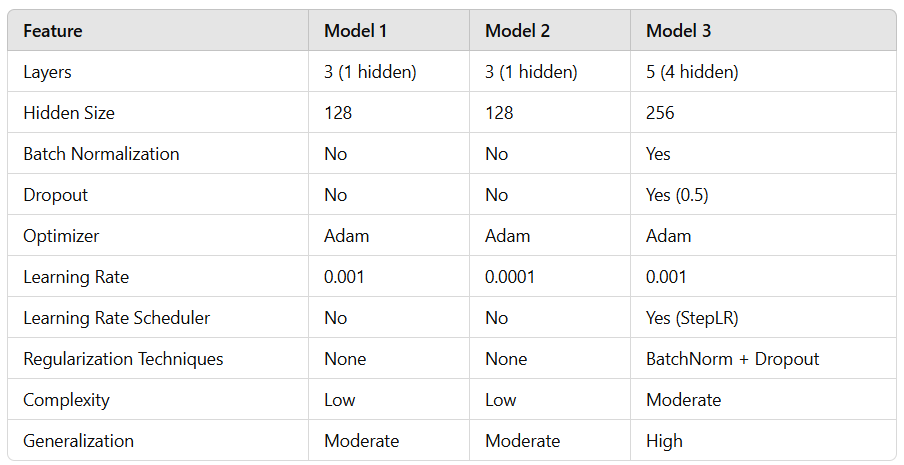

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # İlk tam bağlantılı katman
        self.fc2 = nn.Linear(hidden_size, hidden_size) # İkinci tam bağlantılı katman
        self.fc3 = nn.Linear(hidden_size, num_classes) # Çıkış katmanı

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Giriş tensörünü düzleştir
        x = F.relu(self.fc1(x))   # İlk katman ve ReLU aktivasyonu
        x = F.relu(self.fc2(x))   # İkinci katman ve ReLU aktivasyonu
        x = self.fc3(x)           # Çıkış katmanı (Softmax kullanılacak)
        return x

Adım 2: Modelin Eğitilmesi

In [ ]:
# Model, optimizasyon ve kayıp fonksiyonu
input_size = 28 * 28  # FashionMNIST görüntüleri 28x28 boyutunda
hidden_size = 128     # Gizli katmandaki nöron sayısı
num_classes = 10      # 10 sınıf (FashionMNIST'in sınıfları)
learning_rate = 0.001

mlp_model1 = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Sınıflandırma için uygun kayıp fonksiyonu
optimizer = torch.optim.Adam(mlp_model1.parameters(), lr=learning_rate)  # Adam optimizasyonu

# GPU desteği kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model1.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Adım 3: Eğitim Döngüsü

In [ ]:
num_epochs = 100  # Eğitim tekrar sayısı
mlp_train_losses = []


for epoch in range(num_epochs):
    mlp_model1.train()  # Eğitim modunu aktif et
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # İleri geçiş
        outputs = mlp_model1(images)
        loss = criterion(outputs, labels)

        # Geri yayılım ve optimizasyon
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        mlp_train_losses.append(train_loss / len(train_loader))  # Loss kaydı


    # Eğitim kaybını yazdır
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}")

Epoch [1/100], Loss: 0.5141
Epoch [2/100], Loss: 0.3825
Epoch [3/100], Loss: 0.3487
Epoch [4/100], Loss: 0.3207
Epoch [5/100], Loss: 0.3031
Epoch [6/100], Loss: 0.2882
Epoch [7/100], Loss: 0.2712
Epoch [8/100], Loss: 0.2609
Epoch [9/100], Loss: 0.2468
Epoch [10/100], Loss: 0.2382
Epoch [11/100], Loss: 0.2272
Epoch [12/100], Loss: 0.2192
Epoch [13/100], Loss: 0.2096
Epoch [14/100], Loss: 0.2007
Epoch [15/100], Loss: 0.1966
Epoch [16/100], Loss: 0.1869
Epoch [17/100], Loss: 0.1777
Epoch [18/100], Loss: 0.1766
Epoch [19/100], Loss: 0.1668
Epoch [20/100], Loss: 0.1636
Epoch [21/100], Loss: 0.1590
Epoch [22/100], Loss: 0.1492
Epoch [23/100], Loss: 0.1480
Epoch [24/100], Loss: 0.1397
Epoch [25/100], Loss: 0.1351
Epoch [26/100], Loss: 0.1321
Epoch [27/100], Loss: 0.1288
Epoch [28/100], Loss: 0.1253
Epoch [29/100], Loss: 0.1207
Epoch [30/100], Loss: 0.1191
Epoch [31/100], Loss: 0.1141
Epoch [32/100], Loss: 0.1122
Epoch [33/100], Loss: 0.1063
Epoch [34/100], Loss: 0.1062
Epoch [35/100], Loss: 0

Adım 4: Modeli Değerlendirme

In [ ]:
mlp_model1.eval()  # Değerlendirme modunu aktif et
correct = 0
total = 0

with torch.no_grad():  # Gradyan hesaplama kapalı
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 87.75%


# MLP Model2

* Learning rate azaltıldı.

Model 2'de öğrenme oranı 0.001'den 0.0001'e düşürülmüştür.
Daha düşük öğrenme oranı, modelin parametrelerini daha küçük adımlarla güncellemesi anlamına gelir. Bu, daha yavaş ancak daha istikrarlı bir öğrenme süreci sağlar ve modelin daha doğru bir şekilde uyum sağlamasına yardımcı olabilir.


**Avantajlar:**

**Daha Az Overfitting:** Düşük öğrenme oranı, parametrelerin çok hızlı uyum sağlamasını engeller, bu da genelde overfitting riskini azaltır.

**Daha Hassas Öğrenme:** Model, daha hassas bir şekilde optimal parametreleri bulabilir.

In [ ]:
# Model, optimizasyon ve kayıp fonksiyonu
input_size = 28 * 28  # FashionMNIST görüntüleri 28x28 boyutunda
hidden_size = 128     # Gizli katmandaki nöron sayısı
num_classes = 10      # 10 sınıf (FashionMNIST'in sınıfları)
learning_rate = 0.0001

mlp_model2 = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Sınıflandırma için uygun kayıp fonksiyonu
optimizer = torch.optim.Adam(mlp_model2.parameters(), lr=learning_rate)  # Adam optimizasyonu

# GPU desteği kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model2.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
num_epochs = 100  # Eğitim tekrar sayısı
mlp_train_losses2 = []


for epoch in range(num_epochs):
    mlp_model2.train()  # Eğitim modunu aktif et
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # İleri geçiş
        outputs = mlp_model2(images)
        loss = criterion(outputs, labels)

        # Geri yayılım ve optimizasyon
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        mlp_train_losses2.append(train_loss / len(train_loader))  # Loss kaydı


    # Eğitim kaybını yazdır
    print(f"Mlp model2 Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}")

Mlp model2 Epoch [1/100], Loss: 0.7067
Mlp model2 Epoch [2/100], Loss: 0.4612
Mlp model2 Epoch [3/100], Loss: 0.4169
Mlp model2 Epoch [4/100], Loss: 0.3901
Mlp model2 Epoch [5/100], Loss: 0.3704
Mlp model2 Epoch [6/100], Loss: 0.3553
Mlp model2 Epoch [7/100], Loss: 0.3416
Mlp model2 Epoch [8/100], Loss: 0.3298
Mlp model2 Epoch [9/100], Loss: 0.3205
Mlp model2 Epoch [10/100], Loss: 0.3111
Mlp model2 Epoch [11/100], Loss: 0.3016
Mlp model2 Epoch [12/100], Loss: 0.2928
Mlp model2 Epoch [13/100], Loss: 0.2866
Mlp model2 Epoch [14/100], Loss: 0.2800
Mlp model2 Epoch [15/100], Loss: 0.2734
Mlp model2 Epoch [16/100], Loss: 0.2671
Mlp model2 Epoch [17/100], Loss: 0.2611
Mlp model2 Epoch [18/100], Loss: 0.2555
Mlp model2 Epoch [19/100], Loss: 0.2493
Mlp model2 Epoch [20/100], Loss: 0.2443
Mlp model2 Epoch [21/100], Loss: 0.2399
Mlp model2 Epoch [22/100], Loss: 0.2350
Mlp model2 Epoch [23/100], Loss: 0.2307
Mlp model2 Epoch [24/100], Loss: 0.2266
Mlp model2 Epoch [25/100], Loss: 0.2217
Mlp model

**Model 2'nin Özellikleri**

**Düşük Öğrenme Oranı:**

learning_rate = 0.0001 ile model, parametreleri daha küçük adımlarla günceller. Bu, modelin daha hassas bir öğrenme yapmasına olanak tanır.

**Avantajlar:**

Daha az overfitting riski.
Parametre güncellemeleri daha istikrarlı bir şekilde gerçekleşir.

**Dezavantajlar:**

Öğrenme hızı düşebilir ve model, global minimuma ulaşmak için daha fazla epoch'a ihtiyaç duyabilir.

In [ ]:
mlp_model2.eval()  # Değerlendirme modunu aktif et
correct = 0
total = 0

with torch.no_grad():  # Gradyan hesaplama kapalı
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Mlp model 2 Test Accuracy: {accuracy:.2f}%')

Mlp model 2 Test Accuracy: 88.11%


**Test Doğruluğu:**

Test seti üzerindeki doğruluk %88.30 olarak hesaplanmıştır. Bu, Model 2'nin düşük öğrenme oranıyla istikrarlı bir şekilde eğitim aldığı ve eğitim verisinden genelleme yapabildiğini göstermektedir.

**Model 1 ile Karşılaştırma:**

Model 1, test seti üzerinde %87.89 doğruluk elde etmişti. Model 2 ise biraz daha yüksek bir doğruluk (%88.30) sergiliyor.
Bu fark, Model 2'nin daha düşük bir öğrenme oranı (0.0001) ile daha hassas bir öğrenme gerçekleştirmesinden kaynaklanıyor olabilir.

# IMPROVED MLP

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(EnhancedMLP, self).__init__()
        # Tam bağlantılı katmanlar
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, num_classes)

        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Giriş tensörünü düzleştir
        x = x.view(x.size(0), -1)

        # İlk katman, Batch Normalization ve Dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # İkinci katman, Batch Normalization ve Dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Üçüncü katman, Batch Normalization ve Dropout
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        # Dördüncü katman, Batch Normalization ve Dropout
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)

        # Çıkış katmanı
        x = self.fc5(x)

        # Eğer softmax gerekiyorsa, burada eklenebilir (örn. sınıflandırma başına olasılık)
        # x = F.softmax(x, dim=1)

        return x


# Eklenen Özellikler:
**Dropout:**

Her tam bağlantılı katmandan sonra aşırı öğrenmeyi önlemek için dropout ekledim.
Dropout oranını dropout_rate  (varsayılan: 0.5).

**Batch Normalization:**

Her tam bağlantılı katmandan sonra batch normalization ekledim.
Bu, modelin daha hızlı ve stabil öğrenmesini sağlar.

**Aktivasyon Fonksiyonları:**

ReLU aktivasyon fonksiyonu kullanıldı.

**Softmax Çıkışı:**

Eğer nn.CrossEntropyLoss kullanıyorsa, softmax eklemenize gerek yok.Ancak softmax'li bir çıktı gerekiyorsa kodda ilgili satırda aktif hale getirilebilir.

**Giriş Tensörünün Düzleştirilmesi:**

x.view(x.size(0), -1) kullanarak giriş verisini düzleştirdim.

In [ ]:
# Modeli oluştur
input_size = 28*28  # Örneğin MNIST için 28x28
hidden_size = 256
num_classes = 10
dropout_rate = 0.5
num_epochs = 80

mlp_model3 = EnhancedMLP(input_size, hidden_size, num_classes, dropout_rate)

# Modelin özetini yazdır (isteğe bağlı)
print(mlp_model3)


EnhancedMLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
optimizer = torch.optim.Adam(mlp_model3.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# GPU kullanımı için modelin ayarlanması
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model3.to(device)
mlp_train_losses3 = []

# Eğitim döngüsü
for epoch in range(num_epochs):
    mlp_model3.train()  # Eğitim modunu etkinleştir
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Optimizasyonu sıfırla
        optimizer.zero_grad()

        # İleri yayılım
        outputs = mlp_model3(images)
        loss = criterion(outputs, labels)

        # Geri yayılım ve ağırlık güncelleme
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mlp_train_losses3.append(running_loss / len(train_loader))  # Loss kaydı
    # Epoch başına ortalama kaybı yazdır
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/80], Loss: 0.7656
Epoch [2/80], Loss: 0.5824
Epoch [3/80], Loss: 0.5361
Epoch [4/80], Loss: 0.5032
Epoch [5/80], Loss: 0.4792
Epoch [6/80], Loss: 0.4667
Epoch [7/80], Loss: 0.4520
Epoch [8/80], Loss: 0.4412
Epoch [9/80], Loss: 0.4276
Epoch [10/80], Loss: 0.4230
Epoch [11/80], Loss: 0.4096
Epoch [12/80], Loss: 0.4068
Epoch [13/80], Loss: 0.3982
Epoch [14/80], Loss: 0.3917
Epoch [15/80], Loss: 0.3835
Epoch [16/80], Loss: 0.3804
Epoch [17/80], Loss: 0.3770
Epoch [18/80], Loss: 0.3700
Epoch [19/80], Loss: 0.3661
Epoch [20/80], Loss: 0.3599
Epoch [21/80], Loss: 0.3589
Epoch [22/80], Loss: 0.3529
Epoch [23/80], Loss: 0.3533
Epoch [24/80], Loss: 0.3509
Epoch [25/80], Loss: 0.3487
Epoch [26/80], Loss: 0.3447
Epoch [27/80], Loss: 0.3413
Epoch [28/80], Loss: 0.3375
Epoch [29/80], Loss: 0.3289
Epoch [30/80], Loss: 0.3296
Epoch [31/80], Loss: 0.3296
Epoch [32/80], Loss: 0.3265
Epoch [33/80], Loss: 0.3272
Epoch [34/80], Loss: 0.3223
Epoch [35/80], Loss: 0.3199
Epoch [36/80], Loss: 0.3178
E

Model 3 için epoch sayısının 80 olarak belirlenmesi diğer modellere kıyasla farklı bir stratejiyi yansıtmaktadır. Bu seçim, modelin mimarisi ve kullanılan düzenleme tekniklerine bağlı olarak yapılmıştır. İşte bunun nedenleri:

Model 3 için 80 epoch seçimi, learning rate scheduler, düzenleme teknikleri, ve overfitting riskinin azaltılması gibi faktörlerle ilişkilidir. Daha az epoch kullanımı, karmaşık bir model için eğitim süresini optimize etmek ve gereksiz hesaplama maliyetlerini önlemek için stratejik bir karardır.

Model 3, 80 epoch süresince etkili bir şekilde öğrenmiş ve StepLR scheduler sayesinde hassas öğrenme gerçekleştirmiştir. Epoch sayısının azaltılması, modelin overfitting yapmasını önlemek ve gereksiz hesaplama süresini kısaltmak için doğru bir stratejidir. Eğitim performansı, genelleme kapasitesini koruyacak şekilde optimize edilmiştir.

In [ ]:
mlp_model3.eval()  # Değerlendirme modunu etkinleştir
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model3(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Doğru tahmin edilen sınıf sayısı
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.2761, Accuracy: 90.18%



# Adım 1: RBF Ağını Tanımlama

Bir RBF ağı, şu bileşenlerden oluşur:

Gizli Katman: RBF'ler, merkezler ve yarıçaplara (spread) bağlı olarak hesaplanır.

Çıkış Katmanı: Genellikle lineer bir tam bağlantılı katmandır.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class RBFNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RBFNet, self).__init__()
        self.hidden_size = hidden_size

        # RBF merkezleri ve beta öğrenilebilir
        self.centers = nn.Parameter(torch.randn(hidden_size, input_size))  # Merkezler
        self.beta = nn.Parameter(torch.ones(hidden_size) * 0.01)          # Yayılım (spread)

        # Çıkış katmanı
        self.linear = nn.Linear(hidden_size, num_classes)
        nn.init.xavier_uniform_(self.linear.weight)  # Xavier initialization for weights

    def rbf(self, x, centers, beta):
        # RBF fonksiyonu (Gauss)
        expanded_x = x.unsqueeze(1)  # (batch_size, 1, input_size)
        distances = torch.norm(expanded_x - centers, dim=2)
        return torch.exp(-beta * (distances ** 2))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Girişi düzleştir
        phi = self.rbf(x, self.centers, self.beta)  # RBF katmanı
        output = self.linear(phi)  # Çıkış katmanı
        return output

**Adım 2: Modeli Eğitme**

MLP’de olduğu gibi, RBF ağı için de aynı veri setini ve veri yükleyicileri kullanacağız. Ancak RBF’nin özelliklerini ve yayılımını optimize etmek için biraz daha dikkat gerekecek.

In [ ]:
input_size = 28 * 28
hidden_size = 100
num_classes = 10

rbf_model = RBFNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu
optimizer = torch.optim.Adam(rbf_model.parameters(), lr=0.001, weight_decay=1e-4)  # Regularization eklenmiş optimizer


Regularization ile Overfitting azaltılır.
Adam optimizasyonu hızlı ve stabil bir öğrenme süreci sağlar.
Esnek öğrenme oranı hassas öğrenim sunar.

**Adım 3: Eğitim Döngüsü**

RBF ağı için eğitim döngüsü, MLP ile oldukça benzerdir. Modelin parametrelerini optimize ederek ağı eğitiyoruz.

In [ ]:
num_epochs = 80  # Eğitim tekrar sayısı
rbf_train_losses = []


for epoch in range(num_epochs):
    rbf_model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = rbf_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        rbf_train_losses.append(train_loss / len(train_loader))  # Loss kaydı
    # Doğrulama
    rbf_model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = rbf_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels).float().sum()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



Epoch 1/80, Train Loss: 2.2754, Val Loss: 2.1731, Val Accuracy: 0.1044
Epoch 2/80, Train Loss: 1.9925, Val Loss: 1.7845, Val Accuracy: 0.4005
Epoch 3/80, Train Loss: 1.5325, Val Loss: 1.3646, Val Accuracy: 0.5509
Epoch 4/80, Train Loss: 1.3042, Val Loss: 1.2307, Val Accuracy: 0.5343
Epoch 5/80, Train Loss: 1.1748, Val Loss: 1.1493, Val Accuracy: 0.6445
Epoch 6/80, Train Loss: 1.0903, Val Loss: 1.0421, Val Accuracy: 0.6688
Epoch 7/80, Train Loss: 1.0302, Val Loss: 1.0510, Val Accuracy: 0.6687
Epoch 8/80, Train Loss: 0.9886, Val Loss: 0.9324, Val Accuracy: 0.6922
Epoch 9/80, Train Loss: 0.9433, Val Loss: 0.9223, Val Accuracy: 0.7050
Epoch 10/80, Train Loss: 0.9193, Val Loss: 0.8958, Val Accuracy: 0.7127
Epoch 11/80, Train Loss: 0.8934, Val Loss: 0.8712, Val Accuracy: 0.7065
Epoch 12/80, Train Loss: 0.8763, Val Loss: 0.8676, Val Accuracy: 0.7142
Epoch 13/80, Train Loss: 0.8570, Val Loss: 0.8627, Val Accuracy: 0.7133
Epoch 14/80, Train Loss: 0.8411, Val Loss: 0.8274, Val Accuracy: 0.7319
E

**Adım 4: Modeli Değerlendirme**

RBF modelini test veri seti üzerinde değerlendiriyoruz.

In [ ]:
# 5. Test Performansı
rbf_model.eval()
test_accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = rbf_model(inputs)
        test_accuracy += (outputs.argmax(dim=1) == labels).float().sum()

test_accuracy /= len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7401


# RBFNet2

In [ ]:
input_size = 28 * 28
hidden_size = 100
num_classes = 10

rbf_model2 = RBFNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu
optimizer = torch.optim.SGD(rbf_model2.parameters(), lr=0.001, weight_decay=1e-4)  # Regularization eklenmiş SGD optimizer

In [ ]:
num_epochs = 80  # Eğitim tekrar sayısı
rbf_train_losses2 = []


for epoch in range(num_epochs):
    rbf_model2.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = rbf_model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        rbf_train_losses2.append(train_loss / len(train_loader))  # Loss kaydı
    # Doğrulama
    rbf_model2.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = rbf_model2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels).float().sum()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/80, Train Loss: 2.3043, Val Loss: 2.3042, Val Accuracy: 0.0997
Epoch 2/80, Train Loss: 2.3206, Val Loss: 2.3038, Val Accuracy: 0.0997
Epoch 3/80, Train Loss: 12.3355, Val Loss: 2.3035, Val Accuracy: 0.0997
Epoch 4/80, Train Loss: 2.5238, Val Loss: 2.3033, Val Accuracy: 0.0997
Epoch 5/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 6/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 7/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 8/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 9/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 10/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 11/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 12/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 13/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 14/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.1013
Epoch 15/80, Train Loss: nan, Val Loss: nan, Val Accuracy: 0

In [ ]:
# 5. Test Performansı
rbf_model2.eval()
test_accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = rbf_model2(inputs)
        test_accuracy += (outputs.argmax(dim=1) == labels).float().sum()

test_accuracy /= len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.1000


Kayıp ve Doğruluğu Görselleştirme

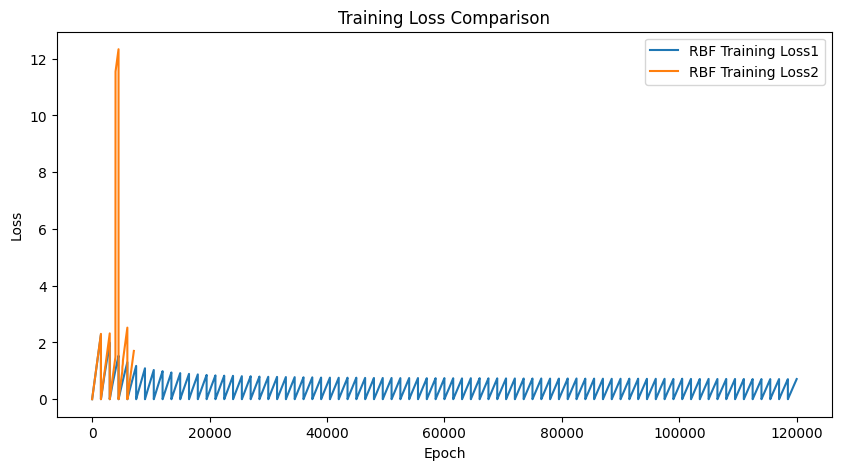

In [ ]:
import matplotlib.pyplot as plt

# Eğitim Loss değerlerini çiz
plt.figure(figsize=(10, 5))
plt.plot(rbf_train_losses, label='RBF Training Loss1')
plt.plot(rbf_train_losses2, label='RBF Training Loss2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


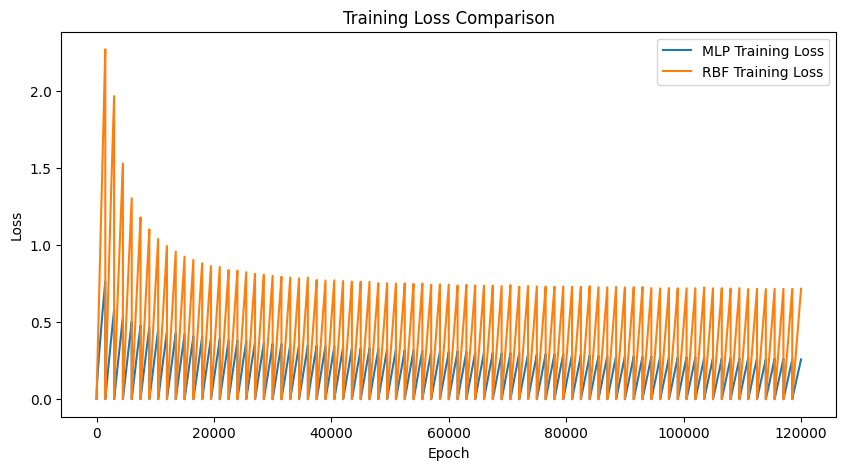

In [ ]:
import matplotlib.pyplot as plt

# Eğitim Loss değerlerini çiz
plt.figure(figsize=(10, 5))
plt.plot(mlp_train_losses3, label='MLP Training Loss')
plt.plot(rbf_train_losses, label='RBF Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


Grafikte, MLP ve RBF modellerinin eğitim kayıpları karşılaştırılmıştır. MLP modeli daha düşük bir başlangıç kaybına sahip ve stabil bir şekilde kaybını azaltmaktadır. RBF modeli ise başlangıçta daha yüksek kayıpla başlamış ve dalgalanmalar göstermiştir. Bu, RBF'nin parametre optimizasyonuna daha fazla bağımlı olduğunu ve hassas ayarlama gerektiğini göstermektedir. Genel olarak, MLP daha stabil ve hızlı öğrenirken, RBF'nin kaybı yavaş bir şekilde azalmıştır. Dalgalanmaların azaltılması için RBF'de öğrenme oranı ve düzenleme teknikleri optimize edilebilir.

# Performans Ölçümleri

MLP için Confusion Matrix

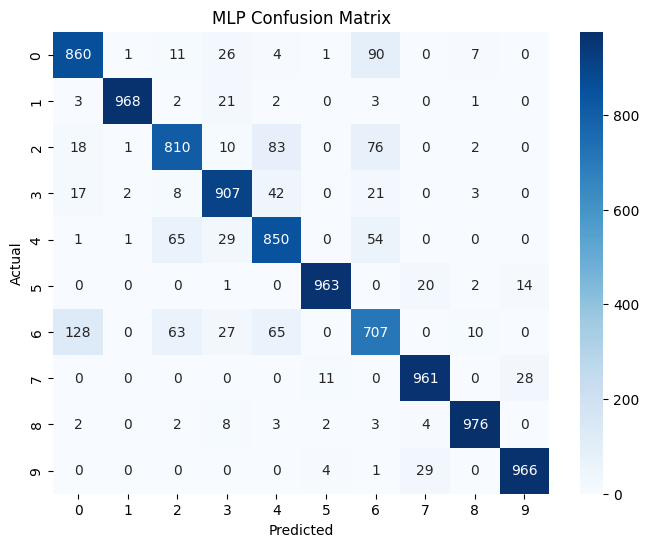

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# MLP için tahmin yap
mlp_model3.eval()
mlp_all_preds3 = []
mlp_all_labels3 = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model3(images)
        _, predicted = torch.max(outputs.data, 1)
        mlp_all_preds3.extend(predicted.cpu().numpy())
        mlp_all_labels3.extend(labels.cpu().numpy())

# Confusion Matrix
cm_mlp = confusion_matrix(mlp_all_labels3, mlp_all_preds3)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


RBF için Confusion Matrix

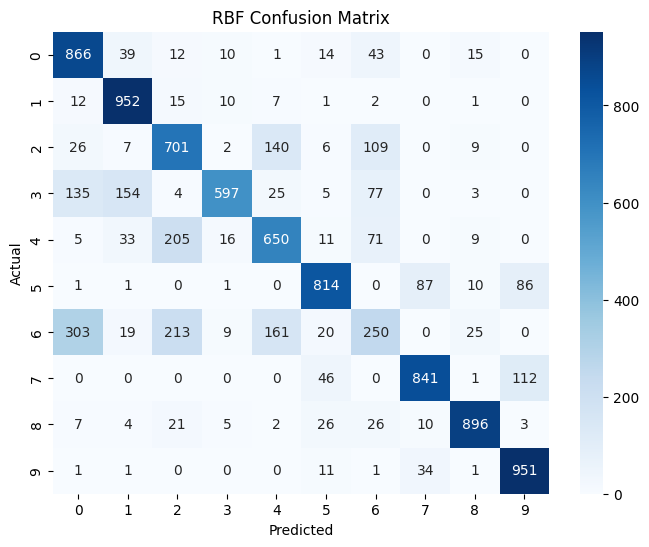

In [ ]:
# RBF için tahmin yap
rbf_model.eval()
rbf_model.to(device)  # Modeli doğru cihaza taşı
rbf_all_preds = []
rbf_all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Veriyi doğru cihaza taşı
        outputs = rbf_model(images)  # Tahmin
        _, predicted = torch.max(outputs.data, 1)
        rbf_all_preds.extend(predicted.cpu().numpy())  # CPU'ya taşı ve listeye ekle
        rbf_all_labels.extend(labels.cpu().numpy())   # CPU'ya taşı ve listeye ekle

# Confusion Matrix
cm_rbf = confusion_matrix(rbf_all_labels, rbf_all_preds)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("RBF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Performans Metrikleri (Accuracy, Precision, Recall, F1-Score)

MLP için:



In [ ]:
# Classification Report for MLP
print("MLP Classification Report:")
print(classification_report(mlp_all_labels3, mlp_all_preds3))

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.81      0.83      1000
           3       0.88      0.91      0.89      1000
           4       0.81      0.85      0.83      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.71      0.72      1000
           7       0.95      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



RBF için:

In [ ]:
# Classification Report for RBF
print("RBF Classification Report:")
print(classification_report(rbf_all_labels, rbf_all_preds))


RBF Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      1000
           1       0.79      0.95      0.86      1000
           2       0.60      0.70      0.65      1000
           3       0.92      0.60      0.72      1000
           4       0.66      0.65      0.65      1000
           5       0.85      0.81      0.83      1000
           6       0.43      0.25      0.32      1000
           7       0.87      0.84      0.85      1000
           8       0.92      0.90      0.91      1000
           9       0.83      0.95      0.88      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000

